In [36]:
import numpy as np
from scipy.optimize import minimize
import numpy.linalg as ln
import numdifftools as nd 
import matplotlib.pyplot as plt
from matplotlib import cm

In [55]:
def golden_section_search(f, a, b, tol=1e-5):
    gr = (np.sqrt(5) + 1) / 2 - 1
    c = b - gr * (b - a)
    d = a + gr * (b - a)

    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        c = b - gr * (b - a)
        d = a + gr * (b - a)

    return (b + a) / 2

def bfgs_method(x0, elipson, delta, K, f):
    x = x0
    k = 0
    N = len(x0)
    I = np.eye(N, dtype=int)
    Hk = I
    f_x = None
    pk = None
   #################
    gradient = nd.Gradient(f)(x)

    
    print('gradient', gradient, ln.norm(gradient))
    print('x', x)

    while ln.norm(gradient) > elipson and k < K:
        f_x = f(x)
    
        pk = -np.dot(Hk, gradient)

        objective_function = lambda alpha: f(x + alpha * pk)
        alpha_k = golden_section_search(objective_function, 0, 1, tol=delta)

        xkp1 = x + alpha_k * pk
        sk = xkp1 - x
        x = xkp1

        fderxp1 = nd.Gradient(f)(xkp1)
        yk = fderxp1 - gradient
        gradient = fderxp1

        k += 1

        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])
        
    if f_x is not None:
        return x, f_x, np.linalg.norm(pk), k
    else: return (x, )

In [58]:
def func(x):
    # return (x[0] - 3 )**2 + (x[1] - 2)**2 #min, max
    return (x[0] - 2 )**2 + (x[1] - 4)**2 #min, max

constraints = [
    # lambda x: 2*x[0] + 3*x[1]  - 12,
    # lambda x: 2*x[0] + x[1] - 10,
    
    lambda x: 2*x[0] + x[1] - 6,
    lambda x: 2*x[0] + 5*x[1]  - 30
]

In [59]:
def penalty_function(x, c, f, g, p):
    penalty = f(x) + c / 2 * sum([max(0, gi(x))**p  for gi in g])
    return penalty

def constrained_optimization(f, g, x0, c0, p, epsilon, K=5):
    x = x0
    c = c0
    k = 0
    prev = float('inf')
    
    while True:
        penalty_func = lambda x: penalty_function(x, c, f, g, p)

        result = bfgs_method(x, epsilon, epsilon, K=500, f=penalty_func)
        #print(result)

        x = result[0]

        if (all([gi(x) <= 0 for gi in g]) and (x[0] > 0 and x[1] > 0) and (abs(prev - penalty_func(x))) < epsilon) or (k >= K):
            break
        
        c *= 2
        prev = penalty_func(x)
        k += 1
    
    return x, f(x), penalty_func(x), k

# Початкові значення
x0 = np.array([1000, 1000])
#n_sum = int (input("enter N:"))
#x0 = np.full(n_sum, 1)
c0 = 1.0
p = 2
epsilon = 1e-6

result = constrained_optimization(func, constraints, x0, c0, p, epsilon)
result

gradient [21924. 39836.] 45470.52531035626
x [1000 1000]
gradient [1.14285612 0.57142844] 1.2777521544308625
x [1.42857128 3.71428583]
gradient [1.33333338 0.66666637] 1.490711894345854
x [1.33333339 3.66666654]
gradient [1.45454565 0.7272731 ] 1.6262315993791416
x [1.27272722 3.63636375]
gradient [1.52380947 0.76190447] 1.703670659854682
x [1.23809529 3.61904751]
gradient [1.56097572 0.78048812] 1.7452240305037272
x [1.21951215 3.6097562 ]


(array([1.20987659, 3.60493817]), 0.7803688455764337, 0.7901234567901366, 5)

In [23]:
def plot_u(u, xmin=-1, xmax=1, ymin=-1, ymax=1, nsteps=20, x=None):
    ax = plt.subplot(projection='3d')

    X = np.linspace(xmin, xmax, nsteps)
    Y = np.linspace(ymin, ymax, nsteps)
    X, Y = np.meshgrid(X, Y)

    f2 = lambda x, y: u(np.array([x, y]))

    Z = np.vectorize(f2)(X, Y)

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False, alpha=.3)
    plt.colorbar(surf, shrink=0.5, aspect=10)

    if x is not None:
        ax.scatter(x[0], x[1], u(x), 'r.')

    plt.show()

In [60]:
penalty = lambda x: penalty_function(x, 2, func, constraints, p)

penalty(np.array([2, 4]))

4.0

In [42]:
minimize(lambda x: penalty_function(x, 2, func, constraints, p), np.array([10, 10]), method='BFGS')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.7595550422962775e-12
        x: [ 3.000e+00  2.000e+00]
      nit: 12
      jac: [ 1.782e-06 -2.799e-06]
 hess_inv: [[ 4.937e-01  9.968e-03]
            [ 9.968e-03  4.843e-01]]
     nfev: 45
     njev: 15

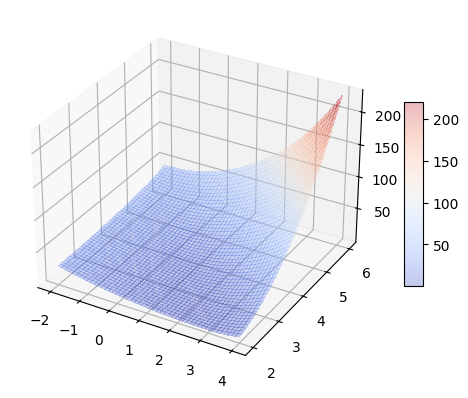

In [48]:
plot_u(lambda x: penalty_function(x, 2, func, constraints, p), -2, 4, 2, 6, 50)